In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)
print("\n")

train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")
print(train_dir,"\n")
print(test_dir)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training 

/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing


In [27]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']

#resizing image to 150*150 pixel
image_size = 150

#Training dataset
for i in labels:
    folderPath = os.path.join('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

#Testing dataset
for i in labels:
    folderPath = os.path.join('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 300/300 [00:00<00:00, 827.86it/s]


In [28]:
print(f"Total number of images in X_train: {X_train.shape[0]}")
print(f"Total number of labels in y_train: {y_train.shape[0]}")
print(f"Shape of images: {X_train.shape[1:]}")

Total number of images in X_train: 7023
Total number of labels in y_train: 7023
Shape of images: (150, 150, 3)


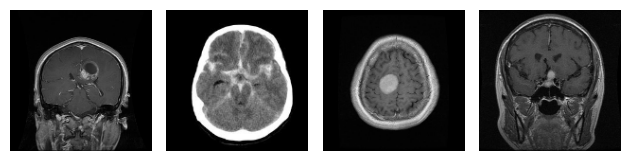

In [31]:
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [33]:
y_train = np.array(pd.get_dummies(y_train))
y_valid = np.array(pd.get_dummies(y_valid))
y_test = np.array(pd.get_dummies(y_test))

In [34]:
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

In [37]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train, seed=42)

In [38]:
callBack = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [44]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(vgg_base.output)

# Fully connected block 1
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting

# Fully connected block 2
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Fully connected block 3
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
out = Dense(4, activation='softmax')(x)

# Define the final model
vgg_model = Model(inputs=vgg_base.input, outputs=out)

# Compile the model
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

vgg_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,855,300 (64.30 MB)

 Trainable params: 2,139,716 (8.16 MB)

 Non-trainable params: 14,715,584 (56.14 MB)

In [13]:
model = Model(inputs=vgg_base.input, outputs=out)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
vgg16_history =model.fit(
    datagen.flow(X_train, y_train, batch_size=15),
    validation_data=(X_valid,y_valid),
    epochs=20,
    callbacks=callBack,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 73s 162ms/step - accuracy: 0.4583 - loss: 1.5563 - val_accuracy: 0.7437 - val_loss: 0.6090 - learning_rate: 0.0010
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.6453 - loss: 0.8827 - val_accuracy: 0.8544 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.7038 - loss: 0.7636 - val_accuracy: 0.8734 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.7434 - loss: 0.6667 - val_accuracy: 0.8750 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.7644 - loss: 0.6188 - val_accuracy: 0.8861 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.7569 - loss: 0.6318 - val_accuracy: 0.8718 - val_loss: 0.3420 - learning_rate: 0.0010
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.7857 - loss: 0.

In [16]:
vgg16_eval = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", vgg16_eval)

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 543ms/step - accuracy: 0.8760 - loss: 0.3375
[test loss, test accuracy]: [0.33600184321403503, 0.8762446641921997]


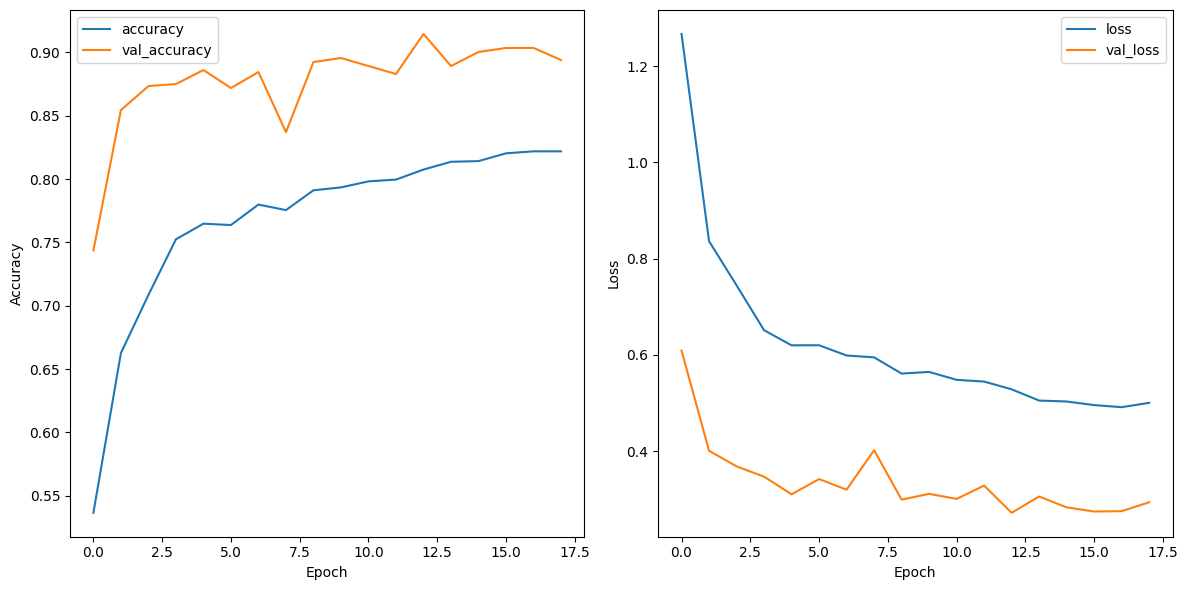

In [46]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='loss')
plt.plot(vgg16_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       176
           1       0.75      0.80      0.77       160
           2       0.94      0.96      0.95       201
           3       0.86      0.98      0.92       166

    accuracy                           0.88       703
   macro avg       0.88      0.87      0.87       703
weighted avg       0.88      0.88      0.88       703

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predicted label: pituitary
Confidence: 92.58%
Actual label: pituitary


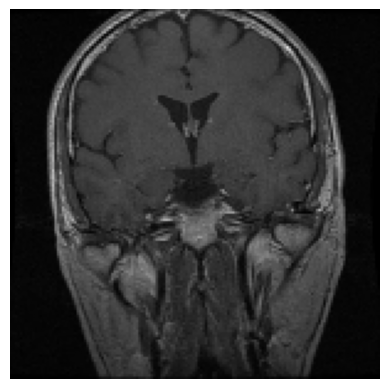

In [43]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
from sklearn.metrics import classification_report

y_true_test = np.argmax(y_test, axis=1)

y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_true_test, y_pred_test))

random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

print(f"\nPredicted label: {predicted_label}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Actual label: {labels[y_true_test[random_index]]}")

plt.imshow(random_img)
plt.axis('off')
plt.show()